In [126]:
import dowhy
from causalgraphicalmodels import CausalGraphicalModel
from sklearn.model_selection import train_test_split
import pandas as pd
import sys
sys.path.append("../scripts/")
import warnings
warnings.filterwarnings('ignore')
from dowhy import CausalModel
from IPython.display import Image, display

In [127]:
df = pd.read_csv("../data/cleaned_data.csv")
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.078710,...,17.33,184.60,2019.0,0.162200,0.665600,0.7119,0.2654,0.460100,0.118900,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.056670,...,23.41,158.80,1956.0,0.123800,0.186600,0.2416,0.1860,0.275000,0.089020,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.059990,...,25.53,152.50,1709.0,0.144400,0.424500,0.4504,0.2430,0.361300,0.087580,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.062798,...,26.50,98.87,567.7,0.132369,0.254265,0.6869,0.2575,0.290076,0.083946,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.058830,...,16.67,152.20,1575.0,0.137400,0.205000,0.4000,0.1625,0.236400,0.076780,1


In [128]:
df['concave points_worst'][df['diagnosis']==1].describe()

count    212.000000
mean       0.182237
std        0.046308
min        0.028990
25%        0.152750
50%        0.182000
75%        0.210675
max        0.291000
Name: concave points_worst, dtype: float64

In [129]:
df['low_concave_points_worst'] = df['concave points_worst'].apply(lambda x: True if x < 0.18 else False)

In [130]:
train,test = train_test_split(df,test_size=0.2)

In [131]:
train_features = {'diagnosis','radius','area','perimeter','compactness','smoothness','concave points','concave_points','concavity'}
train_columns = [col for col in df 
                      if any(feature in col for feature in train_features)]
train_columns

['radius_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'radius_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'diagnosis',
 'low_concave_points_worst']

In [132]:
training = df[train_columns]
training = training.drop(training.filter(regex = '_mean').columns,axis=1)
training = training.drop(training.filter(regex = '_se').columns,axis=1)
training.rename(columns={'concave points_worst':'concave_points_worst'},inplace=True)
training.head()

,radius_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,diagnosis,low_concave_points_worst
0,25.38,184.60,2019.0,0.162200,0.665600,0.7119,0.2654,1,False
1,24.99,158.80,1956.0,0.123800,0.186600,0.2416,0.1860,1,False
2,23.57,152.50,1709.0,0.144400,0.424500,0.4504,0.2430,1,False
3,14.91,98.87,567.7,0.132369,0.254265,0.6869,0.2575,1,False
4,22.54,152.20,1575.0,0.137400,0.205000,0.4000,0.1625,1,True


In [133]:
causal_graph = """
digraph{
radius_worst;
perimeter_worst;
area_worst;
smoothness_worst;
compactness_worst;
concavity_worst;
concave_points_worst;
low_concave_points_worst;
U[label="Unobserved Confounders"];
radius_worst -> perimeter_worst;radius_worst -> area_worst;
perimeter_worst -> area_worst;perimeter_worst -> compactness_worst;
area_worst -> compactness_worst;
compactness_worst -> smoothness_worst;
concave_points_worst -> concavity_worst;
concave_points_worst -> low_concave_points_worst;
concave_points_worst -> smoothness_worst;
U->compactness_worst;U->smoothness_worst;U->concavity_worst;U->low_concave_points_worst;U->diagnosis;
compactness_worst->diagnosis;smoothness_worst->diagnosis;concavity_worst->diagnosis;low_concave_points_worst->diagnosis;
}
"""

In [134]:
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='low_concave_points_worst',
        outcome='diagnosis')

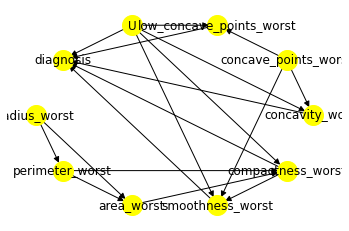

In [135]:
model.view_model()

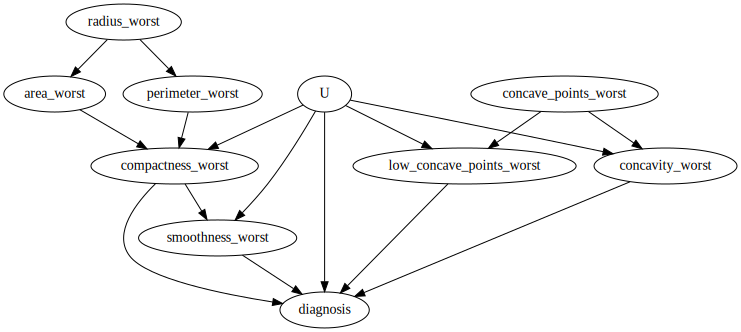

In [136]:
#area and perimeter functions of radius
from causalgraphicalmodels import CausalGraphicalModel
causal = CausalGraphicalModel(
    nodes=['radius_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst',
           'concave_points_worst','diagnosis','low_concave_points_worst','U'],
    edges=[
        ("radius_worst", "perimeter_worst"), 
        ("radius_worst", "area_worst"),
        ("compactness_worst","smoothness_worst"),
        ("concave_points_worst","low_concave_points_worst"),
        ("area_worst","compactness_worst"),
        ("perimeter_worst","compactness_worst"),
        ("concave_points_worst","concavity_worst"),
        ("U","compactness_worst"),
        ("U","smoothness_worst"),
        ("U","concavity_worst"),
        ("U","low_concave_points_worst"),
        ("U","diagnosis"),
        ("low_concave_points_worst","diagnosis"),
        ("smoothness_worst","diagnosis"),
        ("concavity_worst","diagnosis"),
        ("compactness_worst","diagnosis")
    ]
)
# draw return a graphviz `dot` object, which jupyter can render
causal.draw()

### Identify the Causal Effect

In [137]:
estimands = model.identify_effect()
print(estimands)

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
             d                                                                
───────────────────────────(Expectation(diagnosis|smoothness_worst,concavity_w
d[low_concave_points_worst]                                                   

                                                                              
orst,radius_worst,concave_points_worst,compactness_worst,area_worst,perimeter_
                                                                              

       
worst))
       
Estimand assumption 1, Unconfoundedness: If U→{low_concave_points_worst} and U→diagnosis then P(diagnosis|low_concave_points_worst,smoothness_worst,concavity_worst,radius_worst,concave_points_worst,compactness_worst,area_worst,perimeter_worst,U) = P(diagnosis|low_

### Estimate the Causal Effect based on the statistical method

In [139]:
#Causal Effect Estimation
#Method based on estimating the treatment assignment
estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
             d                                                                
───────────────────────────(Expectation(diagnosis|smoothness_worst,concavity_w
d[low_concave_points_worst]                                                   

                                                                              
orst,radius_worst,concave_points_worst,compactness_worst,area_worst,perimeter_
                                                                              

       
worst))
       
Estimand assumption 1, Unconfoundedness: If U→{low_concave_points_worst} and U→diagnosis then P(diagnosis|low_concave_points_worst,smoothness_worst,concavity_worst,radius_worst,concave_points_worst,compactness_worst,area_worst,perimeter_worst,U) = P(diagnosis|low_concave_points_worst,smoothness_worst,concavity_worst,radius_worst,concave_points_worst,comp

### From the result above, we can say that the probability of a breast tumour being diagnosed as malignant reduces by 6%, when the worst concave point measure is less than 0.18

In [141]:
refute_train = model.refute_estimate(estimands,estimate, "random_common_cause")
print(refute_train)

Refute: Add a Random Common Cause
Estimated effect:-0.06332412975827095
New effect:-0.043263816776494546



### The new effect acacquired after testing the assumption is approximately the same as the estimated effect which means the assumption is correct

### We therefore conclude that a low worst concave point measure has a causal effect on a tumour being diagnosed as malignant